Docs:
- https://docs.manim.community/en/stable/examples.html#basic-concepts
- https://docs.manim.community/en/stable/reference/manim.mobject.mobject.Mobject.html#manim.mobject.mobject.Mobject.get_point_mobject

In [1]:
from manim import *

Manim Community v0.18.0

In [2]:
class SquareToCircle(Scene):
    def construct(self):
        circle = Circle()  # create a circle
        circle.set_fill(PINK, opacity=0.5)  # set color and transparency

        square = Square()  # create a square
        square.rotate(PI / 4)  # rotate a certain amount

        self.play(Create(square))  # animate the creation of the square
        self.play(Transform(square, circle))  # interpolate the square into the circle
        self.play(FadeOut(square))  # fade out animation

In [138]:
%manim -qm -v WARNING SquareToCircle

## Showing Rectangles
Here I'm going to attempt to create several rectangles similar to what a convolutional layer would look like

In [80]:
class FeatureMap(Scene):
    def construct(self):
        for i in range(3):
            rectangle = Rectangle(height=3, width=3, stroke_color=BLUE)
            rectangle.set_fill(BLUE, opacity=0.2)
            rectangle.rotate(about_point=rectangle.get_center(),axis = [0.02, 1, 0], angle=75*DEGREES)
            rectangle.move_to([-3+(i/3), 0, 0])
            self.add(rectangle)

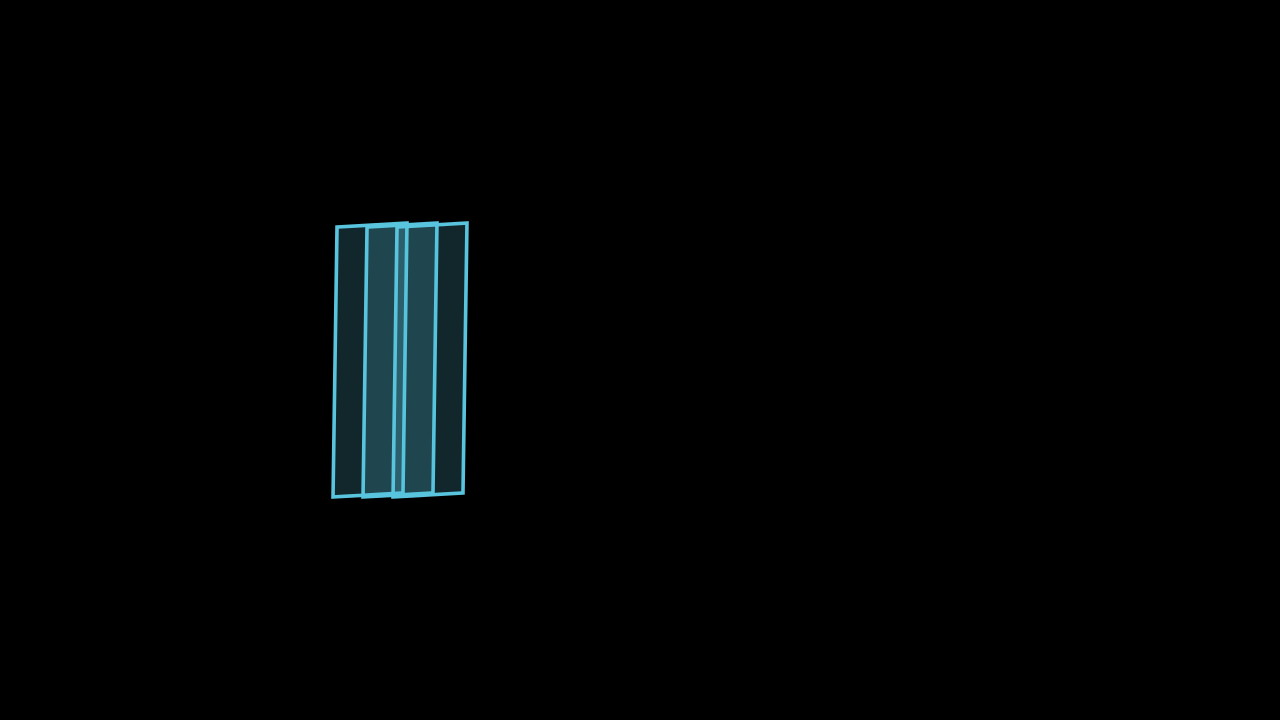

In [81]:
%manim -qm -v WARNING FeatureMap

In [82]:
rectangle = Rectangle(height=3, width=3)
rectangle.get_all_points().min(axis=0)
# rectangle.has_points()

def get_corners_of_rectangle(rectangle):
    return [
        rectangle.get_corner(DL),
        rectangle.get_corner(DR),
        rectangle.get_corner(UL),
        rectangle.get_corner(UR),
    ]
# get_corners_of_rectangle(rectangle)

def create_corners_dict(rectangle):
    corners_dict = {
        "top_left": Dot(rectangle.get_corner(UL)),
        "top_right": Dot(rectangle.get_corner(UR)),
        "bottom_left": Dot(rectangle.get_corner(DL)),
        "bottom_right": Dot(rectangle.get_corner(DR)),
    }
    return corners_dict

create_corners_dict(rectangle)['top_left'].rotate(about_point=rectangle.get_center(),axis = [0.02, 1, 0], angle=75*DEGREES).get_center()

array([-0.36644656,  1.47732893,  1.47757103])

Create the gridded rectangle that is used for convolution

In [83]:
class GriddedRectangle(Scene):
    def construct(self):
        height = 3
        width = 3
        rectangle = Rectangle(height=height, width=width,
                              stroke_color=BLUE)
        rectangle.set_fill(BLUE, opacity=0.2)

        grid_lines = VGroup()
        v = rectangle.get_vertices()
        grid_xstep = 1
        count = 3 / grid_xstep

        gridx = VGroup(
            *(
                Line(
                    v[1] + i * grid_xstep * RIGHT,
                    v[1] + i * grid_xstep * RIGHT + height * DOWN,
                    stroke_color = BLUE,
                    stroke_width = 1,
                    stroke_opacity = 1,
                    shade_in_3d = True,
                )
                for i in range(1, int(count))
            )
        )

        grid_lines.add(gridx)

        gridy = VGroup(
            *(
                Line(
                    v[1] + i * grid_xstep * DOWN,
                    v[1] + i * grid_xstep * DOWN + width * RIGHT,
                    stroke_color = BLUE,
                    stroke_width = 1,
                    stroke_opacity = 1,
                    shade_in_3d = True,
                )
                for i in range(1, int(count))
            )
        )

        grid_lines.add(gridy)
        
        self.add(grid_lines)
        self.add(rectangle)


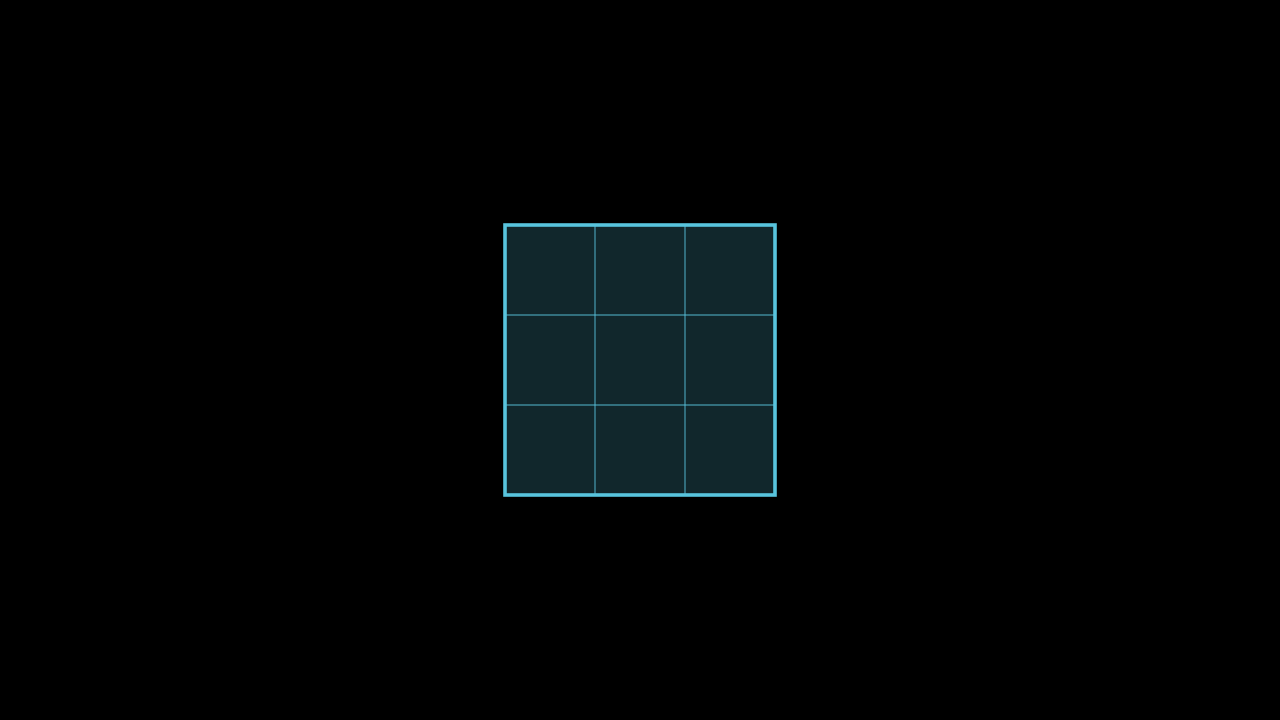

In [84]:
%manim -qm -v WARNING GriddedRectangle

# Create Rectangle Classes

In [79]:
import numpy as np
class ConvLayer(VGroup):
    def __init__(self, num_layers=3, height=4, width=5, z_lvl=1, **kwargs):
        super().__init__()
        self.num_layers = num_layers
        self.height = height
        self.width = width

        self.ancs = np.full((num_layers, 4, 3), np.nan)
        # Define the shapes and add them to self
        for i in range(num_layers):
            rectangle = Rectangle(height=height, width=width, stroke_color=BLUE)
            rectangle.set_fill(BLUE, opacity=0.2)
            # rectangle.rotate(about_point=rectangle.get_center(),axis = [0.02, 1, 0], angle=75*DEGREES)
            rectangle.move_to([0, 0, z_lvl-(i/3)])

            self.ancs[i,:,:] = self.get_corners_of_rectangle(rectangle)
            
            self.add(rectangle)
    
    @property
    def ancs_v2(self):
        return self.get_corners_of_rectangle(self.submobjects[self.num_layers - 1])


    @staticmethod
    def get_corners_of_rectangle(rectangle):
        
        corners = np.full((4,3), np.nan)

        for i in enumerate([UL, UR, DL, DR]):
            corners[i[0],:] = rectangle.get_corner(i[1])
        
        return corners

In [80]:
class GriddedRectangle(VGroup):
    def __init__(self, height=3, width=3, **kwargs):
        super().__init__()
        rectangle = Rectangle(height=height, width=width,
                              stroke_color=BLUE)
        rectangle.set_fill(BLUE, opacity=0.2)

        grid_lines = VGroup()
        v = rectangle.get_vertices()
        grid_xstep = 1
        grid_ystep = 1
        countx = width / grid_xstep

        gridx = VGroup(
            *(
                Line(
                    v[1] + i * grid_xstep * RIGHT,
                    v[1] + i * grid_xstep * RIGHT + height * DOWN,
                    stroke_color = BLUE,
                    stroke_width = 1,
                    stroke_opacity = 1,
                    shade_in_3d = True,
                )
                for i in range(1, int(countx))
            )
        )

        grid_lines.add(gridx)

        county = height / grid_ystep
        gridy = VGroup(
            *(
                Line(
                    v[1] + i * grid_xstep * DOWN,
                    v[1] + i * grid_xstep * DOWN + width * RIGHT,
                    stroke_color = BLUE,
                    stroke_width = 1,
                    stroke_opacity = 1,
                    shade_in_3d = True,
                )
                for i in range(1, int(county))
            )
        )

        grid_lines.add(gridy)
        
        self.add(grid_lines)
        self.add(rectangle)

class ConnectionLines(VGroup):
    def __init__(self, grid_recs):
        super().__init__()
        lines = []
        
        for i in [UL, UR, DL, DR]:
            # print(f'{i} Line from {grid_recs[0].get_corner(i)} to {grid_recs[2].get_corner(i)}')
            line = Line(grid_recs[0].get_corner(i), grid_recs[2].get_corner(i),
                        stroke_color=ORANGE,
                        stroke_width=10,
                        stroke_opacity = 1)
            lines.append(line)
        lines = VGroup(*lines)
        grid_recs = VGroup(*grid_recs)
        self.add(lines)
        self.add(grid_recs)

In [93]:
class testscene(Scene):
    def construct(self):
        conv_layer = ConvLayer(num_layers=3)

        grid_recs = []
        for i in range(3):
            grid_rec = GriddedRectangle()
            grid_rec.align_to(conv_layer.ancs[i,0,:], direction=UL)
            grid_rec.set_z(conv_layer.ancs[i,0,-1])

            grid_recs.append(grid_rec)
            
        conv_layer2 = ConvLayer(num_layers=1, height=2, width=3, z_lvl=6)
        grid_recs2 = []
        for i in range(1):
            grid_rec = GriddedRectangle(height=1, width=1)
            grid_rec.align_to(conv_layer2.ancs[i,0,:], direction=UL)
            grid_rec.set_z(conv_layer2.ancs[i,0,-1])

            grid_recs2.append(grid_rec)


        grid_recs = self.make_connection_lines(grid_recs, grid_recs2)
        # grid_recs = VGroup(*grid_recs)
        
        tot = VGroup(conv_layer, conv_layer2, grid_recs)
        tot.rotate(about_point=tot.get_center(), axis=[0, 1, 0], angle=120*DEGREES)
        self.add(conv_layer)
        self.add(conv_layer2)

        self.play(FadeIn(grid_recs))
        # self.wait(1)
        self.play(ApplyMethod(grid_recs.align_to, conv_layer.ancs_v2[0,:], {'direction':UL}))
        return grid_recs

    @staticmethod
    def make_connection_lines(grid_recs, out_recs=None):
        lines = []
        
        for i in [UL, UR, DL, DR]:
            for j in range(1,len(grid_recs)):
                line = Line(grid_recs[j].get_corner(i), grid_recs[j-1].get_corner(i),
                            stroke_color=ORANGE,
                            stroke_width=10,
                            stroke_opacity = 1)
                lines.append(line)

        if out_recs:
            for i in [UL, UR, DL, DR]:
                for j in range(1,len(out_recs)):
                    line = Line(grid_recs[j].get_corner(i), out_recs[j-1].get_corner(i),
                                stroke_color=ORANGE,
                                stroke_width=5,
                                stroke_opacity = 0)
                    lines.append(line)

                line = Line(grid_recs[0].get_corner(i), out_recs[-1].get_corner(i),
                            stroke_color=ORANGE,
                            stroke_width=5,
                            stroke_opacity = 1)
                lines.append(line)


        return VGroup(VGroup(*lines), VGroup(*grid_recs), VGroup(*out_recs) if out_recs else None)

In [94]:
%manim -qm -v WARNING testscene

# Create NN Scene

In [132]:
class NNLayer(VGroup):
    def __init__(self, num_nodes=3, **kwargs):
        super().__init__()
        self.num_nodes = num_nodes

        self.ancs = np.full((num_nodes, 3), np.nan)
        # Define the shapes and add them to self
        for i in range(num_nodes):
            circle = Circle(radius=0.3, stroke_color=BLUE)
            circle.set_fill(BLUE, opacity=0.2)
            circle.move_to([0, (num_nodes/2)-i, 0])

            self.ancs[i,:] = circle.get_center()
            
            self.add(circle)

In [137]:
class testnn(Scene):
    def construct(self):
        nn_layer = NNLayer(num_nodes=3)

        nn_layer2 = NNLayer(num_nodes=4)
        nn_layer2.shift(RIGHT * 2)

        self.add(nn_layer)
        self.add(nn_layer2)
        self.add(SurroundingRectangle(nn_layer, color=BLUE, fill_opacity=0.1))
        self.add(SurroundingRectangle(nn_layer2, color=BLUE, fill_opacity=0.1))
        self.add(self.connection_lines(nn_layer, nn_layer2))

    @staticmethod
    def connection_lines(nn_layer, nn_layer2):
        lines = []
        for i in range(len(nn_layer)):
            for j in range(len(nn_layer2)):
                line = Line(nn_layer[i].get_center(), nn_layer2[j].get_center(),
                            stroke_color=ORANGE,
                            stroke_width=5,
                            stroke_opacity = 1)
                lines.append(line)

        return VGroup(*lines)

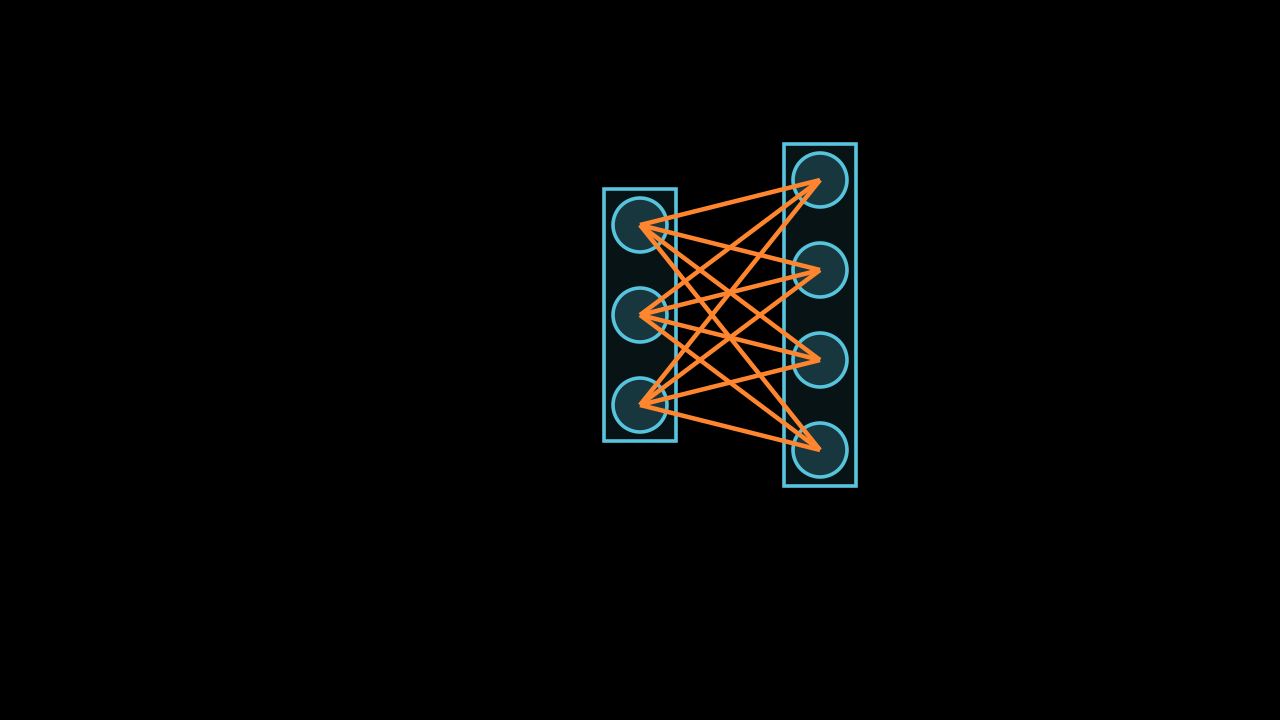

In [138]:
%manim -qm -v WARNING testnn